# Proyek Predictive Analysis: Sticky Price Consumer Price Index less Food and Energy
- **Nama:** Haiqel Aziizul Hakeem
- **Email:** a547ybm193@devacademy.id
- **ID Dicoding:** A547YBM193

## Business Understanding

Pada project kali ini saya akan memprediksi inflasi harga produk yang tidak sering berubah dalam jangka panjang atau biasa disebut Sticky Price Consumer Price Index. Dataset yang digunakan diambil dari website [Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org) dengan judul Sticky Price Consumer Price Index less Food and Energy.

Problem Statements:
* Bagaimana cara kita membangun model secara akurat serta memprediksikan inflasi dari Sticky Price CPI menggunakan arsitektur Deep Learning seperti LSTM,dan Gru?

Goals:
1. Memahami trend dari Sticky Price CPI menggunakan EDA
2. Preprocess dan mengubah data time series ke dalam deep learning model
3. Mengembangkan dan membandingkan model LSTM, dan Gru
4. Evaluasi kinerja model
5. Menentukan model yang terbaik berdasarkan hasil evaluasi

## Import Semua Packages/Library yang Digunakan

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gdown

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

## Data Understanding

### Data Loading

In [ ]:
file_id = '1E_YcQAFTHhoabpdb9RpgdPUSBhL3aA-z'
output_path = 'cpi.csv'
gdown.download(f'https://drive.google.com/uc?id={file_id}', output_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1E_YcQAFTHhoabpdb9RpgdPUSBhL3aA-z
To: /content/cpi.csv
100%|██████████| 27.5k/27.5k [00:00<00:00, 30.8MB/s]


'cpi.csv'

In [ ]:
df = pd.read_csv('cpi.csv')

### EDA and Visualization

In [ ]:
df['observation_date'] = pd.to_datetime(df['observation_date'])
df.rename(columns={'CPALTT01USM657N': 'cpi'}, inplace=True)
df.head()

,observation_date,cpi
0,1955-02-01,0.0
1,1955-03-01,0.0
2,1955-04-01,0.0
3,1955-05-01,0.0
4,1955-06-01,0.0


In [ ]:
print(f"Jumlah baris: {df.shape[0]}\n")
print(f"Jumlah kolom: {df.shape[1]}\n")
print(f"Jumlah data yang hilang: {df.isna().sum().sum()}\n")
print(f"Jumlah data duplikat: {df.duplicated().sum()}\n")
print(f"Tipe data:\n{df.dtypes}\n")
print(f"Statistik data:\n{df.describe()}\n")
print(f"Jumlah nilai unik:\n{df.nunique()}\n")

Jumlah baris: 830

Jumlah kolom: 2

Jumlah data yang hilang: 0

Jumlah data duplikat: 0

Tipe data:
observation_date    datetime64[ns]
cpi                        float64
dtype: object

Statistik data:
                    observation_date         cpi
count                            830  830.000000
mean   1989-08-16 04:53:12.289156608    0.297383
min              1955-02-01 00:00:00   -1.915290
25%              1972-05-08 18:00:00    0.034399
50%              1989-08-16 12:00:00    0.290554
75%              2006-11-23 12:00:00    0.498546
max              2024-03-01 00:00:00    1.805869
std                              NaN    0.355861

Jumlah nilai unik:
observation_date    830
cpi                 705
dtype: int64



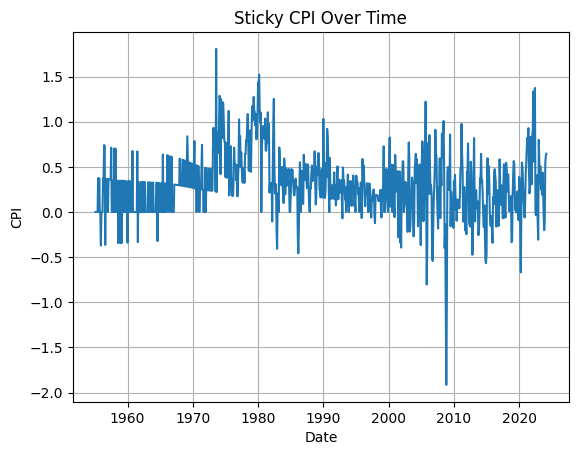

In [ ]:
plt.plot(df['observation_date'], df['cpi'])
plt.title("Sticky CPI Over Time")
plt.xlabel("Date")
plt.ylabel("CPI")
plt.grid(True)
plt.show()

## Data Preparation

In [ ]:
# Normalization
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['cpi']])

# Sequence for LSTM and GRU
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

SEQ_LEN = 12
X, y = create_sequences(scaled, SEQ_LEN)

In [ ]:
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

## Modelling

In [ ]:
callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
        ReduceLROnPlateau(factor=0.5, patience=3, verbose=1)
    ]

In [ ]:
# LSTM
lstm_model = Sequential([
    Input(shape=(SEQ_LEN, 1)),
    LSTM(64, activation='tanh', return_sequences=False),
    Dense(1)
])

In [ ]:
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lstm_history = lstm_model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50,
        batch_size=32,
        callbacks=callbacks,
        verbose=2
    )

Epoch 1/50
21/21 - 1s - 33ms/step - loss: 0.0067 - val_loss: 0.0086 - learning_rate: 1.2500e-04
Epoch 2/50
21/21 - 0s - 12ms/step - loss: 0.0066 - val_loss: 0.0086 - learning_rate: 1.2500e-04
Epoch 3/50
21/21 - 0s - 12ms/step - loss: 0.0067 - val_loss: 0.0086 - learning_rate: 1.2500e-04
Epoch 4/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
21/21 - 0s - 13ms/step - loss: 0.0066 - val_loss: 0.0086 - learning_rate: 1.2500e-04
Epoch 5/50
21/21 - 0s - 12ms/step - loss: 0.0066 - val_loss: 0.0085 - learning_rate: 6.2500e-05
Epoch 6/50
21/21 - 0s - 14ms/step - loss: 0.0067 - val_loss: 0.0086 - learning_rate: 6.2500e-05
Epoch 7/50

Epoch 7: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
21/21 - 0s - 15ms/step - loss: 0.0066 - val_loss: 0.0085 - learning_rate: 6.2500e-05
Epoch 8/50
21/21 - 0s - 12ms/step - loss: 0.0066 - val_loss: 0.0086 - learning_rate: 3.1250e-05
Epoch 9/50
21/21 - 0s - 12ms/step - loss: 0.0066 - val_loss: 0.0086 - learning_

In [ ]:
# Predict and evaluate
lstm_preds = lstm_model.predict(X_test)
lstm_preds_inv = scaler.inverse_transform(lstm_preds)
y_test_inv = scaler.inverse_transform(y_test)

# Calculate error metrics
mae = mean_absolute_error(y_test_inv, lstm_preds_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, lstm_preds_inv))
print(f"LSTM: MAE={mae:.4f}, RMSE={rmse:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
LSTM: MAE=0.2819, RMSE=0.3440


In [ ]:
# GRU
gru_model = Sequential([
    Input(shape=(SEQ_LEN, 1)),
    GRU(64, activation='tanh', return_sequences=False),
    Dense(1)
])

In [ ]:
gru_model.compile(optimizer='adam', loss='mse')
gru_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,929 (50.50 KB)

 Trainable params: 12,929 (50.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
gru_history = gru_model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50,
        batch_size=32,
        callbacks=callbacks,
        verbose=2
    )

Epoch 1/50
21/21 - 3s - 135ms/step - loss: 0.0760 - val_loss: 0.0208 - learning_rate: 1.0000e-03
Epoch 2/50
21/21 - 0s - 15ms/step - loss: 0.0092 - val_loss: 0.0083 - learning_rate: 1.0000e-03
Epoch 3/50
21/21 - 0s - 14ms/step - loss: 0.0067 - val_loss: 0.0079 - learning_rate: 1.0000e-03
Epoch 4/50
21/21 - 0s - 14ms/step - loss: 0.0065 - val_loss: 0.0079 - learning_rate: 1.0000e-03
Epoch 5/50
21/21 - 0s - 14ms/step - loss: 0.0065 - val_loss: 0.0078 - learning_rate: 1.0000e-03
Epoch 6/50
21/21 - 1s - 35ms/step - loss: 0.0064 - val_loss: 0.0077 - learning_rate: 1.0000e-03
Epoch 7/50
21/21 - 0s - 20ms/step - loss: 0.0064 - val_loss: 0.0076 - learning_rate: 1.0000e-03
Epoch 8/50
21/21 - 0s - 21ms/step - loss: 0.0064 - val_loss: 0.0075 - learning_rate: 1.0000e-03
Epoch 9/50
21/21 - 1s - 30ms/step - loss: 0.0063 - val_loss: 0.0077 - learning_rate: 1.0000e-03
Epoch 10/50

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
21/21 - 0s - 16ms/step - loss: 0.0064 - val_l

In [ ]:
# GRU
# Predict and evaluate
gru_preds = gru_model.predict(X_test)
gru_preds_inv = scaler.inverse_transform(gru_preds)
y_test_inv = scaler.inverse_transform(y_test)

# Calculate error metrics
mae = mean_absolute_error(y_test_inv, gru_preds_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, gru_preds_inv))
print(f"GRU: MAE={mae:.4f}, RMSE={rmse:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
GRU: MAE=0.2592, RMSE=0.3182


## Evaluasi dan Visualisasi

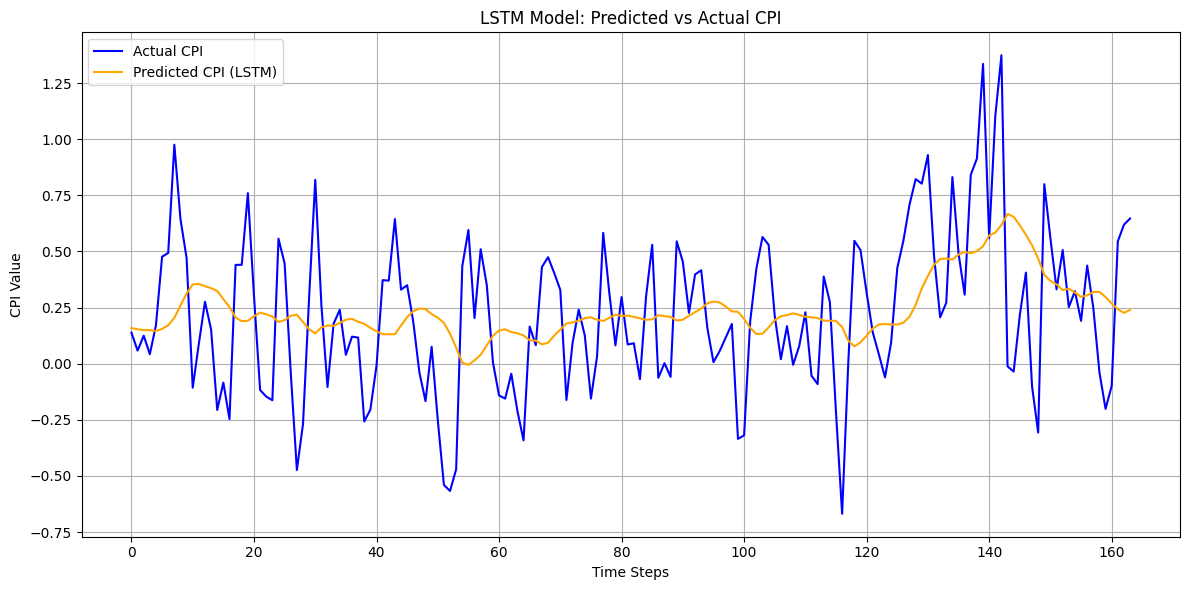

In [ ]:
# LSTM
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual CPI', color='blue')
plt.plot(lstm_preds_inv, label='Predicted CPI (LSTM)', color='orange')
plt.title("LSTM Model: Predicted vs Actual CPI")
plt.xlabel("Time Steps")
plt.ylabel("CPI Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

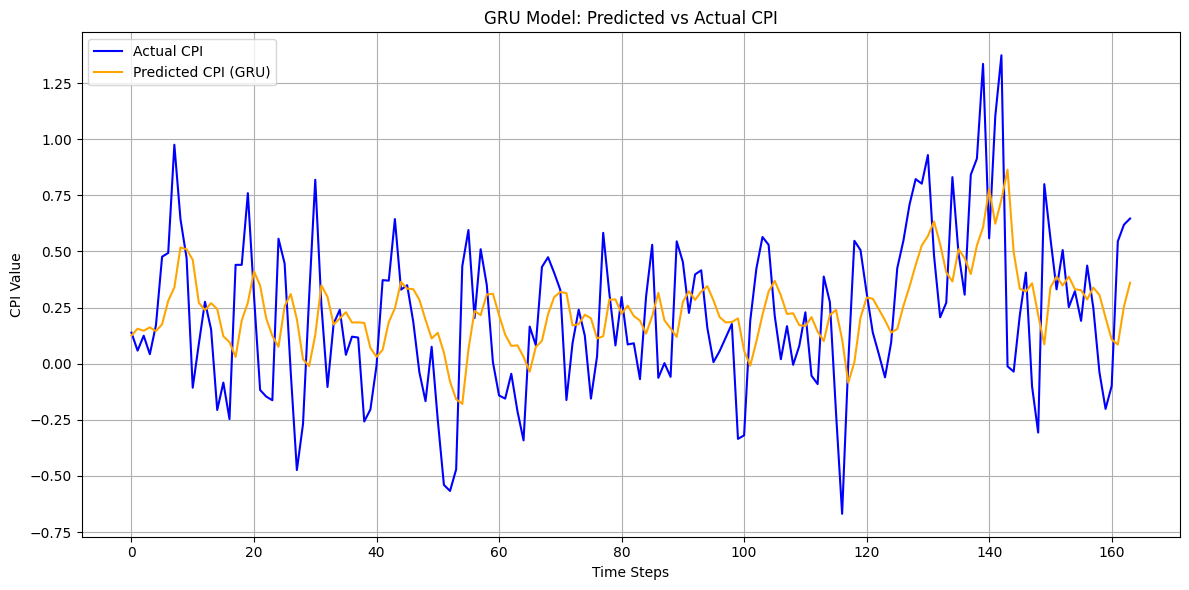

In [ ]:
# GRU

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual CPI', color='blue')
plt.plot(gru_preds_inv, label='Predicted CPI (GRU)', color='orange')
plt.title("GRU Model: Predicted vs Actual CPI")
plt.xlabel("Time Steps")
plt.ylabel("CPI Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Inference

In [ ]:
n_steps = 12
preds = []

input_seq = scaled[-SEQ_LEN:].reshape(1, SEQ_LEN, 1)

for _ in range(n_steps):
    next_pred = gru_model.predict(input_seq)[0, 0]
    preds.append(next_pred)

    # update input_seq: drop first, append new prediction
    input_seq = np.append(input_seq[:, 1:, :], [[[next_pred]]], axis=1)

# Inverse transform all predictions
future_preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


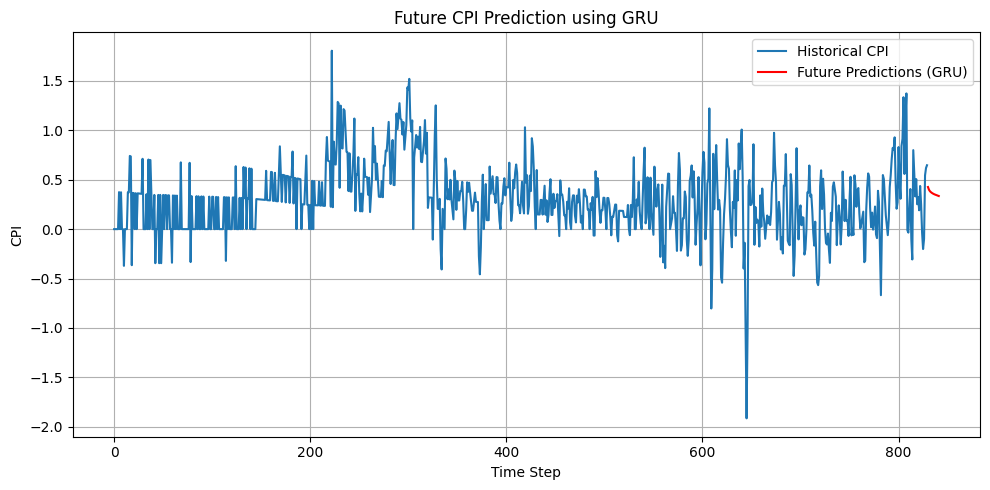

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(scaled)), scaler.inverse_transform(scaled), label='Historical CPI')
plt.plot(range(len(scaled), len(scaled) + n_steps), future_preds, label='Future Predictions (GRU)', color='red')
plt.xlabel('Time Step')
plt.ylabel('CPI')
plt.title('Future CPI Prediction using GRU')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()